# Mechanistic analysis of HTML tags closing in GPT-2

We already know there're from [Gurnee et al. 2023](https://arxiv.org/abs/2305.01610) that there are neurons in transformers that activates for specific code text such as Python and HTML.
In this notebook I will explore how GPT-2 processes HTML code to find how it closes tags. The analysis is divided into two sections:

1. The mechanism that allow the general closure of a tag (the one that predict the `</` token)
2. The mechanism responsible to find the right tag to close (the one that, for example, predict `div` token after the previous)

In [1]:
from transformer_lens import HookedTransformer
import torch
from tqdm import tqdm
import plotly.express as px

DEVICE = 'cuda'

In [2]:
from huggingface_hub import hf_hub_download
from sae_lens import LMSparseAutoencoderSessionloader

REPO_ID = "jbloom/GPT2-Small-SAEs"

layer = 8  # any layer from 0 - 11 works here
FILENAME = f"final_sparse_autoencoder_gpt2-small_blocks.{layer}.hook_resid_pre_24576.pt"

# this is great because if you've already downloaded the SAE it won't download it twice!
path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)

In [3]:
model, sparse_autoencoders, activation_store = (
    LMSparseAutoencoderSessionloader.load_session_from_pretrained(path=path)
)
sparse_autoencoder = [i for i in sparse_autoencoders][0]

sparse_autoencoder.eval()
model.eval()
nl = len(model.blocks)

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


/nlp/scr/ghilardi/miniconda3/lib/python3.11/site-packages/datasets/load.py:1454: FutureWarning: The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Run name: 24576-L1-8e-05-LR-0.0004-Tokens-3.000e+08
n_tokens_per_buffer (millions): 0.524288
Lower bound: n_contexts_per_buffer (millions): 0.004096
Total training steps: 73242
Total wandb updates: 732
n_tokens_per_feature_sampling_window (millions): 524.288
n_tokens_per_dead_feature_window (millions): 2621.44
We will reset the sparsity calculation 73 times.
Number tokens in sparsity calculation window: 4.10e+06
Using Ghost Grads.
Run name: 24576-L1-8e-05-LR-0.0004-Tokens-3.000e+08
n_tokens_per_buffer (millions): 0.524288
Lower bound: n_contexts_per_buffer (millions): 0.004096
Total training steps: 73242
Total wandb updates: 732
n_tokens_per_feature_sampling_window (millions): 524.288
n_tokens_per_dead_feature_window (millions): 2621.44
We will reset the sparsity calculation 73 times.
Number tokens in sparsity calculation window: 4.10e+06
Using Ghost Grads.


In [4]:
# Some useful functions
@torch.no_grad()
def generate(model, prompt, max_new_tokens=10):
    tokens = model.to_tokens(prompt)
    for _ in range(max_new_tokens):
        output = model(tokens)
        next_token = torch.argmax(output[0, -1, :])
        tokens = torch.cat((tokens, next_token.unsqueeze(0).unsqueeze(0)), dim=1)
    return model.tokenizer.decode(tokens[0], skip_special_tokens=True)

### Data

In [39]:
from datasets import load_dataset, Dataset

SEQ_LEN = 128

# Load in the data (it's a Dataset object)
data = load_dataset("NeelNanda/c4-code-20k", split="train")
assert isinstance(data, Dataset)

# Tokenize the data (using a utils function) and shuffle it
tokenized_data = utils.tokenize_and_concatenate(data, model.tokenizer, max_length=SEQ_LEN) # type: ignore
tokenized_data = tokenized_data.shuffle(42)

# Get the tokens as a tensor
all_tokens = tokenized_data["tokens"]
assert isinstance(all_tokens, torch.Tensor)

print(all_tokens.shape)

torch.Size([325017, 128])


In [13]:
closing_tag_idx = [[i for i, token in enumerate(tokens) if token == '</'] for tokens in str_tokens]

In [15]:
tokens.shape

torch.Size([16, 541])

## 1. General closure

Before starting all the experiment, let's spend a moment thinking about the necessary conditions for the model to produce the token `</`, which is very uncommon in natural language. They're two:

1. We are in the context of HTML text,
2. The text inside the tag is about to end.

While the first one is fairly easy to verify and we know there are neurons dedicated to that, the second is much more complex and I expect the model to not always be able to rightly predict the end-tag token. This is similar to predicting the `.` to end a phrase in natural language, it's easy in some cases but very hard in others.

In [30]:
prompt = "<html>\n<head></head>\n<body>\n<p>"
model.tokenizer.tokenize(prompt)

['<',
 'html',
 '>',
 'Ċ',
 '<',
 'head',
 '></',
 'head',
 '>',
 'Ċ',
 '<',
 'body',
 '>',
 'Ċ',
 '<',
 'p',
 '>']

In [31]:
from sae_vis import SaeVisConfig, SaeVisData
from transformer_lens import utils

torch.cuda.empty_cache()
import gc
gc.collect()

dic_size, d_model = sparse_autoencoder.W_dec.shape

for i, features in enumerate(range(0, dic_size, d_model * 4)):
    # Specify the hook point you're using, the features you're analyzing, and the batch size for gathering activations
    sae_vis_config = SaeVisConfig(
        hook_point = utils.get_act_name("resid_pre", 8),
        features = range(features, features + d_model * 4),
        batch_size = 2048,
        verbose = True,
    )

    # Gather the feature data
    sae_vis_data = SaeVisData.create(
        encoder = sparse_autoencoder,
        model = model,
        tokens = all_tokens, # type: ignore
        cfg = sae_vis_config,
    )

    prompt = "<html>\n<head></head>\n<body>\n<p>"

    seq_pos = model.tokenizer.tokenize(prompt).index("html") # type: ignore
    metric = 'act-quantiles'

    filename = f"_prompt_vis_demo_{i}.html"

    sae_vis_data.save_prompt_centric_vis(
        prompt = prompt,
        filename = filename,
        seq_pos = seq_pos, # optional argument, to determine the default option when the page loads
        metric = metric, # optional argument, to determine the default option when the page loads
    )

Forward passes to cache data for vis:   0%|          | 0/384 [00:00<?, ?it/s]

Extracting vis data from cached data:   0%|          | 0/3072 [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Task                                           ┃ Time   ┃ Pct % ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ (1) Initialization                             │ 0.04s  │ 0.0%  │
│ (2) Forward passes to gather model activations │ 73.73s │ 44.6% │
│ (3) Computing feature acts from model acts     │ 2.02s  │ 1.2%  │
│ (4) Getting data for tables                    │ 3.35s  │ 2.0%  │
│ (5) Getting data for histograms                │ 2.06s  │ 1.2%  │
│ (6) Getting data for sequences                 │ 79.89s │ 48.3% │
│ (7) Getting data for quantiles                 │ 4.30s  │ 2.6%  │
└────────────────────────────────────────────────┴────────┴───────┘

Forward passes to cache data for vis:   0%|          | 0/384 [00:00<?, ?it/s]

Extracting vis data from cached data:   0%|          | 0/3072 [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Task                                           ┃ Time   ┃ Pct % ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ (1) Initialization                             │ 0.02s  │ 0.0%  │
│ (2) Forward passes to gather model activations │ 73.69s │ 45.1% │
│ (3) Computing feature acts from model acts     │ 2.02s  │ 1.2%  │
│ (4) Getting data for tables                    │ 3.35s  │ 2.0%  │
│ (5) Getting data for histograms                │ 2.16s  │ 1.3%  │
│ (6) Getting data for sequences                 │ 77.71s │ 47.5% │
│ (7) Getting data for quantiles                 │ 4.54s  │ 2.8%  │
└────────────────────────────────────────────────┴────────┴───────┘

Forward passes to cache data for vis:   0%|          | 0/384 [00:00<?, ?it/s]

Extracting vis data from cached data:   0%|          | 0/3072 [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Task                                           ┃ Time   ┃ Pct % ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ (1) Initialization                             │ 0.02s  │ 0.0%  │
│ (2) Forward passes to gather model activations │ 73.71s │ 45.9% │
│ (3) Computing feature acts from model acts     │ 2.01s  │ 1.3%  │
│ (4) Getting data for tables                    │ 3.35s  │ 2.1%  │
│ (5) Getting data for histograms                │ 2.07s  │ 1.3%  │
│ (6) Getting data for sequences                 │ 75.19s │ 46.8% │
│ (7) Getting data for quantiles                 │ 4.39s  │ 2.7%  │
└────────────────────────────────────────────────┴────────┴───────┘

Forward passes to cache data for vis:   0%|          | 0/384 [00:00<?, ?it/s]

Extracting vis data from cached data:   0%|          | 0/3072 [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Task                                           ┃ Time   ┃ Pct % ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ (1) Initialization                             │ 0.02s  │ 0.0%  │
│ (2) Forward passes to gather model activations │ 73.67s │ 44.3% │
│ (3) Computing feature acts from model acts     │ 2.02s  │ 1.2%  │
│ (4) Getting data for tables                    │ 3.35s  │ 2.0%  │
│ (5) Getting data for histograms                │ 2.07s  │ 1.2%  │
│ (6) Getting data for sequences                 │ 80.68s │ 48.5% │
│ (7) Getting data for quantiles                 │ 4.40s  │ 2.6%  │
└────────────────────────────────────────────────┴────────┴───────┘

Forward passes to cache data for vis:   0%|          | 0/384 [00:00<?, ?it/s]

Extracting vis data from cached data:   0%|          | 0/3072 [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Task                                           ┃ Time   ┃ Pct % ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ (1) Initialization                             │ 0.02s  │ 0.0%  │
│ (2) Forward passes to gather model activations │ 73.72s │ 45.0% │
│ (3) Computing feature acts from model acts     │ 1.99s  │ 1.2%  │
│ (4) Getting data for tables                    │ 3.35s  │ 2.0%  │
│ (5) Getting data for histograms                │ 2.07s  │ 1.3%  │
│ (6) Getting data for sequences                 │ 78.06s │ 47.7% │
│ (7) Getting data for quantiles                 │ 4.46s  │ 2.7%  │
└────────────────────────────────────────────────┴────────┴───────┘

Forward passes to cache data for vis:   0%|          | 0/384 [00:00<?, ?it/s]

Extracting vis data from cached data:   0%|          | 0/3072 [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Task                                           ┃ Time   ┃ Pct % ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ (1) Initialization                             │ 0.02s  │ 0.0%  │
│ (2) Forward passes to gather model activations │ 73.65s │ 43.6% │
│ (3) Computing feature acts from model acts     │ 2.04s  │ 1.2%  │
│ (4) Getting data for tables                    │ 3.34s  │ 2.0%  │
│ (5) Getting data for histograms                │ 2.13s  │ 1.3%  │
│ (6) Getting data for sequences                 │ 83.61s │ 49.5% │
│ (7) Getting data for quantiles                 │ 4.09s  │ 2.4%  │
└────────────────────────────────────────────────┴────────┴───────┘

Forward passes to cache data for vis:   0%|          | 0/384 [00:00<?, ?it/s]

Extracting vis data from cached data:   0%|          | 0/3072 [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Task                                           ┃ Time   ┃ Pct % ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ (1) Initialization                             │ 0.02s  │ 0.0%  │
│ (2) Forward passes to gather model activations │ 73.76s │ 46.0% │
│ (3) Computing feature acts from model acts     │ 2.00s  │ 1.3%  │
│ (4) Getting data for tables                    │ 3.35s  │ 2.1%  │
│ (5) Getting data for histograms                │ 2.43s  │ 1.5%  │
│ (6) Getting data for sequences                 │ 74.56s │ 46.5% │
│ (7) Getting data for quantiles                 │ 4.11s  │ 2.6%  │
└────────────────────────────────────────────────┴────────┴───────┘

Forward passes to cache data for vis:   0%|          | 0/384 [00:00<?, ?it/s]

Extracting vis data from cached data:   0%|          | 0/3072 [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Task                                           ┃ Time   ┃ Pct % ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ (1) Initialization                             │ 0.02s  │ 0.0%  │
│ (2) Forward passes to gather model activations │ 73.69s │ 46.3% │
│ (3) Computing feature acts from model acts     │ 2.05s  │ 1.3%  │
│ (4) Getting data for tables                    │ 3.35s  │ 2.1%  │
│ (5) Getting data for histograms                │ 2.05s  │ 1.3%  │
│ (6) Getting data for sequences                 │ 74.07s │ 46.5% │
│ (7) Getting data for quantiles                 │ 3.94s  │ 2.5%  │
└────────────────────────────────────────────────┴────────┴───────┘

To inspect the second condition we shift to a feature centric perspective and analyse which are the feature that most contribute to the tag-end token.

In [32]:
tok_id = model.to_tokens('</')[0, -1]
tok_id

tensor(3556, device='cuda:0')

In [33]:
model.W_U.shape

torch.Size([768, 50257])

In [37]:
relevant_features = (sparse_autoencoder.W_dec @ model.W_U[:, tok_id, None]).argsort(dim=0, descending=True)[:32, 0].tolist()

[21227, 17052, 23677]

In [38]:
# Specify the hook point you're using, the features you're analyzing, and the batch size for gathering activations
sae_vis_config = SaeVisConfig(
    hook_point = utils.get_act_name("resid_pre", 8),
    features = relevant_features,
    batch_size = 2048,
    verbose = True,
)

# Gather the feature data
sae_vis_data = SaeVisData.create(
    encoder = sparse_autoencoder,
    model = model,
    tokens = all_tokens, # type: ignore
    cfg = sae_vis_config,
)

# Save as HTML file & display vis
filename = "_feature_vis_demo.html"
sae_vis_data.save_feature_centric_vis(filename, feature_idx=21227)

Forward passes to cache data for vis:   0%|          | 0/32 [00:00<?, ?it/s]

Extracting vis data from cached data:   0%|          | 0/32 [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ Task                                           ┃ Time  ┃ Pct % ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ (1) Initialization                             │ 0.00s │ 0.0%  │
│ (2) Forward passes to gather model activations │ 6.03s │ 81.8% │
│ (3) Computing feature acts from model acts     │ 0.15s │ 2.1%  │
│ (4) Getting data for tables                    │ 0.27s │ 3.7%  │
│ (5) Getting data for histograms                │ 0.02s │ 0.3%  │
│ (6) Getting data for sequences                 │ 0.85s │ 11.6% │
│ (7) Getting data for quantiles                 │ 0.04s │ 0.6%  │
└────────────────────────────────────────────────┴───────┴───────┘

Saving feature-centric vis:   0%|          | 0/32 [00:00<?, ?it/s]

## 2. Retrieving the right tag

This part should be easier as it can be expressed by a formal algorithm. A possible circuit can be made by using positinal information and induction heads that attend to tokens next to `'<'` and `'</'` tokens. The former will boost the probabiliy of the token to be the right one, while the second will decrease it. 

In [43]:
from jaxtyping import Float
from transformer_lens import ActivationCache
from transformer_lens.hook_points import HookPoint
from functools import partial
from transformer_lens import utils

def residual_stream_patching_hook(
    resid_pre: Float[torch.Tensor, "batch pos d_model"],
    hook: HookPoint,
    position: int,
    clean_cache: ActivationCache
) -> Float[torch.Tensor, "batch pos d_model"]:
    # Each HookPoint has a name attribute giving the name of the hook.
    clean_resid_pre = clean_cache[hook.name]
    resid_pre[:, position, :] = clean_resid_pre[:, position, :]
    return resid_pre

def logits_to_logit_diff(model, logits, correct_answer, incorrect_answer):
    # model.to_single_token maps a string value of a single token to the token index for that token
    # If the string is not a single token, it raises an error.
    correct_index = model.to_single_token(correct_answer)
    incorrect_index = model.to_single_token(incorrect_answer)
    return logits[0, -1, correct_index] - logits[0, -1, incorrect_index]

@torch.no_grad()
def activation_patching(model, clean_prompt, corrupted_prompt, correct_answer, incorrect_answer, component="hook_resid_post", run_corrupted=True):

    # By default this function runs the corrupted prompt and substitute the clean activations!
    if not run_corrupted:
        clean_prompt, corrupted_prompt = corrupted_prompt, clean_prompt
        correct_answer, incorrect_answer = incorrect_answer, correct_answer

    clean_tokens = model.to_tokens(clean_prompt)
    corrupted_tokens = model.to_tokens(corrupted_prompt)

    # We run on the clean prompt with the cache so we store activations to patch in later.
    clean_logits, clean_cache = model.run_with_cache(clean_tokens, device=DEVICE)
    clean_logit_diff = logits_to_logit_diff(model, clean_logits, correct_answer=correct_answer, incorrect_answer=incorrect_answer)
    print(f"Clean logit difference: {clean_logit_diff.item():.3f}")

    # We don't need to cache on the corrupted prompt.
    corrupted_logits = model(corrupted_tokens)
    corrupted_logit_diff = logits_to_logit_diff(model, corrupted_logits, correct_answer=correct_answer, incorrect_answer=incorrect_answer)
    print(f"Corrupted logit difference: {corrupted_logit_diff.item():.3f}")

    # Run patching
    print("Running patching...")
     # We make a tensor to store the results for each patching run. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
    num_positions = len(clean_tokens[0])
    patching_result = torch.zeros((model.cfg.n_layers, num_positions), device=model.cfg.device)

    for layer in tqdm(range(model.cfg.n_layers)):
        for position in range(num_positions):
            # Use functools.partial to create a temporary hook function with the position fixed
            temp_hook_fn = partial(residual_stream_patching_hook, position=position, clean_cache=clean_cache)
            # Run the model with the patching hook
            patched_logits = model.run_with_hooks(corrupted_tokens, fwd_hooks=[
                (f"blocks.{layer}.{component}", temp_hook_fn)
            ])
            # Calculate the logit difference
            patched_logit_diff = logits_to_logit_diff(model, patched_logits, correct_answer, incorrect_answer).detach()
            # Store the result, normalizing by the clean and corrupted logit difference so it's between 0 and 1 (ish)
            patching_result[layer, position] = (patched_logit_diff - corrupted_logit_diff)/(clean_logit_diff - corrupted_logit_diff)

    return patching_result

In [431]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_ap(model, clean_prompt, corrupted_prompt, correct_ans, incorrect_ans):
    mlp_patching = activation_patching(model, clean_prompt, corrupted_prompt, correct_ans, incorrect_ans, component="hook_mlp_out")
    attn_patching = activation_patching(model, clean_prompt, corrupted_prompt, correct_ans, incorrect_ans, component="hook_attn_out")
    rs_patching = activation_patching(model, clean_prompt, corrupted_prompt, correct_ans, incorrect_ans, component="hook_resid_post")
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=150, layout="tight")

    sns.heatmap(
        mlp_patching.cpu().numpy()[:, 1:], 
        ax=ax[0], 
        xticklabels=model.to_str_tokens(clean_prompt)[1:], 
        yticklabels=[f"Layer {i}" for i in range(model.cfg.n_layers)],
        vmin=-1, vmax=1, cmap='RdBu')
    ax[0].set_title("MLP")

    sns.heatmap(
        attn_patching.cpu().numpy()[:, 1:], 
        ax=ax[1], 
        xticklabels=model.to_str_tokens(clean_prompt)[1:], 
        yticklabels=[f"Layer {i}" for i in range(model.cfg.n_layers)],
        vmin=-1, vmax=1, cmap='RdBu')
    ax[1].set_title("Attention")

    sns.heatmap(
        rs_patching.cpu().numpy()[:, 1:], 
        ax=ax[2], 
        xticklabels=model.to_str_tokens(clean_prompt)[1:], 
        yticklabels=[f"Layer {i}" for i in range(model.cfg.n_layers)],
        vmin=-1, vmax=1, cmap='RdBu')
    ax[2].set_title("Residual Stream")
            
    return fig

def plot_tag_logits(model, prompt, tags, layers):
    with torch.no_grad():
        _, cache = model.run_with_cache(model.to_tokens(prompt))

    logits = [model.unembed(cache[f"blocks.{l}.hook_resid_post"])[0, -1, :] for l in layers]
    proba = torch.cat([torch.softmax(logits, dim=-1)[None] for logits in logits])

    html_tags_tokens = model.to_tokens(tags)[:, 1]
    with torch.no_grad():
        _, cache = model.run_with_cache(model.to_tokens(prompt))

    logits = [model.unembed(cache[f"blocks.{l}.hook_resid_post"])[0, -1, :] for l in range(nl)]
    proba = torch.cat([torch.softmax(logits, dim=-1)[None] for logits in logits])

    fig, ax = plt.subplots(figsize=(2*len(tags), 5), dpi=100)
    sns.heatmap(
        proba[:, html_tags_tokens].cpu().detach(), yticklabels=layers, xticklabels=tags, ax=ax, 
        cmap='Blues', vmin=0, vmax=1, annot=True)
    ax.set_title("Tags Logit Evolution")

    return fig    


def visualize_attn_patter(pattern, prompt):
    fig, ax = plt.subplots(4, 3, figsize=(15, 15), dpi=150, layout='tight')

    for i in range(4):
        for j in range(3):
            sns.heatmap(
                pattern[i*3+j].cpu().numpy()[1:, 1:], 
                ax=ax[i, j], 
                xticklabels=model.to_str_tokens(prompt)[1:], 
                yticklabels=model.to_str_tokens(prompt)[1:],
                vmin=0, vmax=1, cmap='Blues')
            ax[i, j].set_title(f"Layer {i*3+j}")
    
    return fig

### Closing a tag with no other tags

In [423]:
clean_prompt = "<p> write here </"
corrupted_prompt = "<div> write here </"

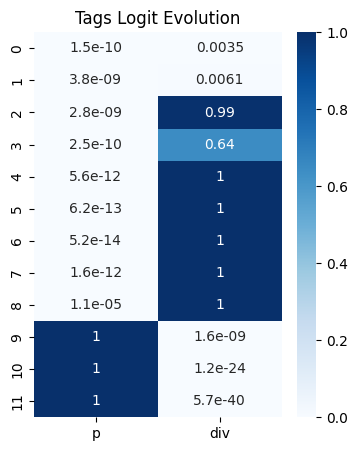

In [424]:
fig = plot_tag_logits(model, clean_prompt, ["p", "div"], range(12))
fig.show()

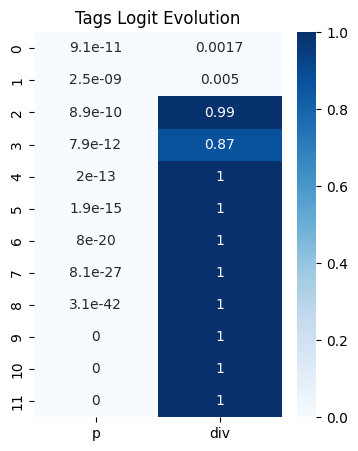

In [425]:
fig = plot_tag_logits(model, corrupted_prompt, ["p", "div"], range(12))
fig.show()

Clean logit difference: 9.132
Corrupted logit difference: -8.904
Running patching...


  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:02<00:00,  4.84it/s]


Clean logit difference: 9.132
Corrupted logit difference: -8.904
Running patching...


100%|██████████| 12/12 [00:01<00:00,  7.29it/s]


Clean logit difference: 9.132
Corrupted logit difference: -8.904
Running patching...


100%|██████████| 12/12 [00:01<00:00,  7.35it/s]


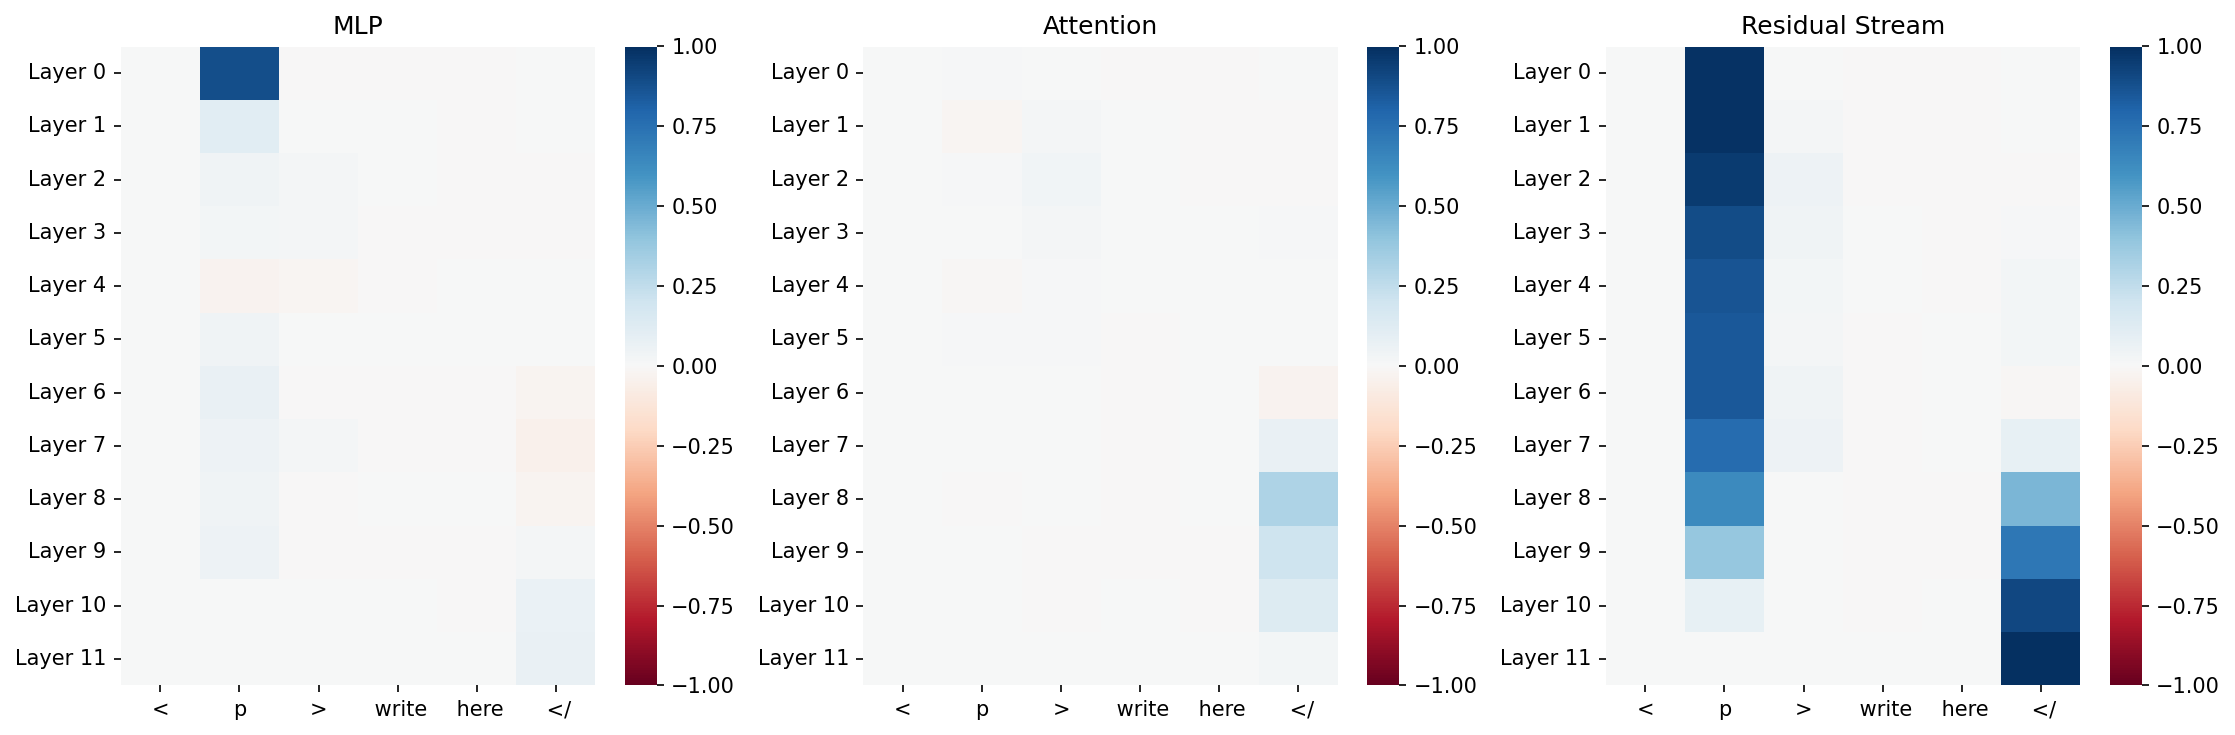

In [430]:
fig = plot_ap(model, clean_prompt, corrupted_prompt, "p", "div")
fig.show()

In [432]:
with torch.no_grad():
    _, cache = model.run_with_cache(model.to_tokens(clean_prompt))

attn_pattern = cache['blocks.8.attn.hook_pattern'][0]

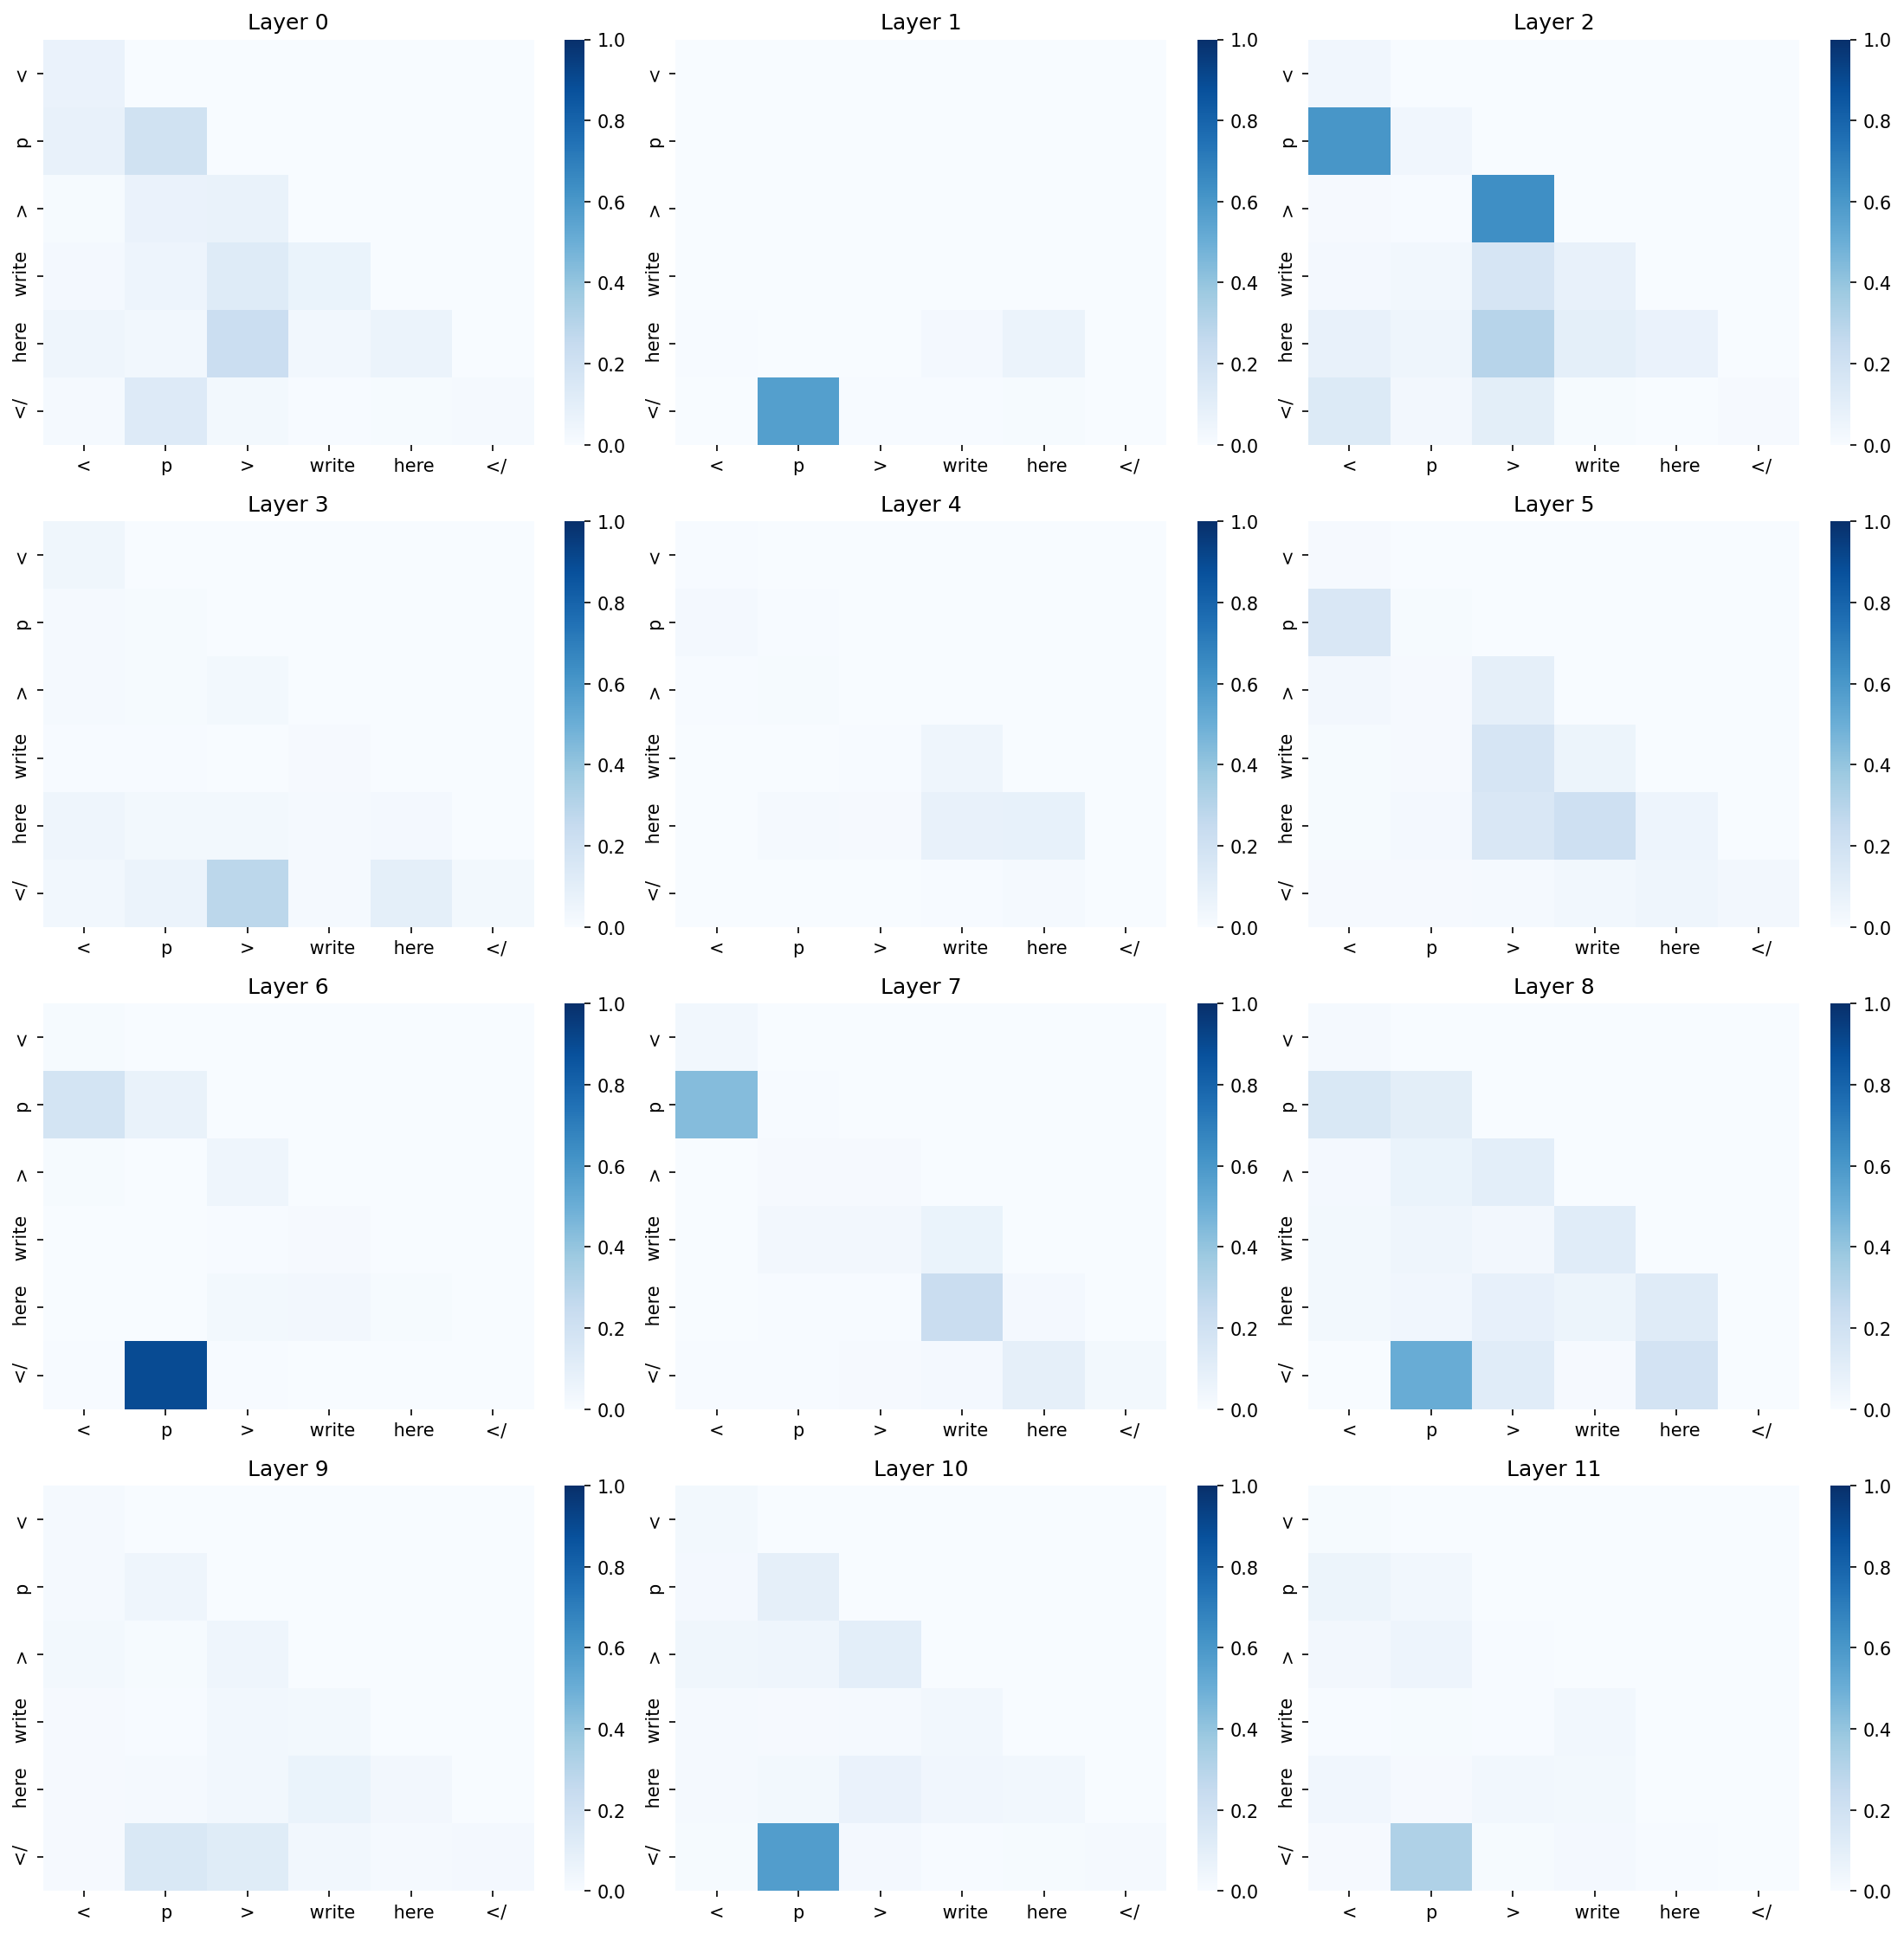

In [433]:
fig = visualize_attn_patter(attn_pattern, clean_prompt)
fig.show()

Seems like token `</` attend to 

### Closing the first tag
When we have two open tags to close I expect the model to use positional information to understand which tags is closer.

In [434]:
clean_prompt = "<div> <a>write something here</"
corrupted_prompt = "<div> <p>write something here</"

clean_tokens = model.to_tokens(clean_prompt)
corrupted_tokens = model.to_tokens(corrupted_prompt)

correct_ans = "a"
incorrect_ans = "p"

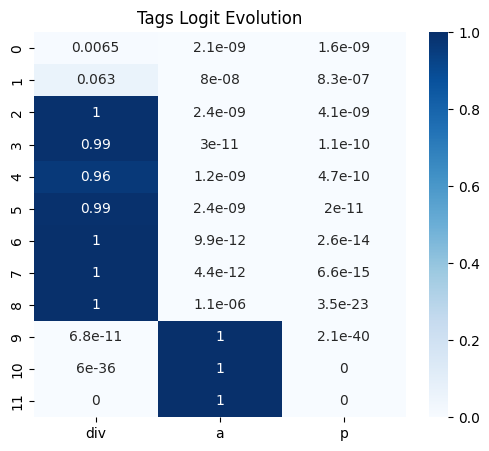

In [435]:
fig = plot_tag_logits(model, clean_prompt, ["div", "a", "p"], range(12))
fig.show()

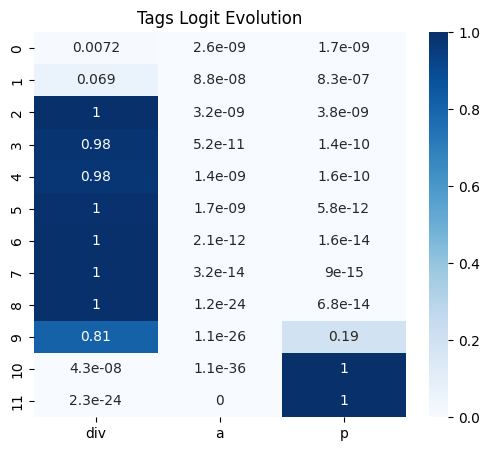

In [436]:
fig = plot_tag_logits(model, corrupted_prompt, ["div", "a", "p"], range(12))
fig.show()

Clean logit difference: 13.516
Corrupted logit difference: -8.265
Running patching...


  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:03<00:00,  3.40it/s]


Clean logit difference: 13.516
Corrupted logit difference: -8.265
Running patching...


100%|██████████| 12/12 [00:02<00:00,  4.81it/s]


Clean logit difference: 13.516
Corrupted logit difference: -8.265
Running patching...


100%|██████████| 12/12 [00:02<00:00,  4.82it/s]


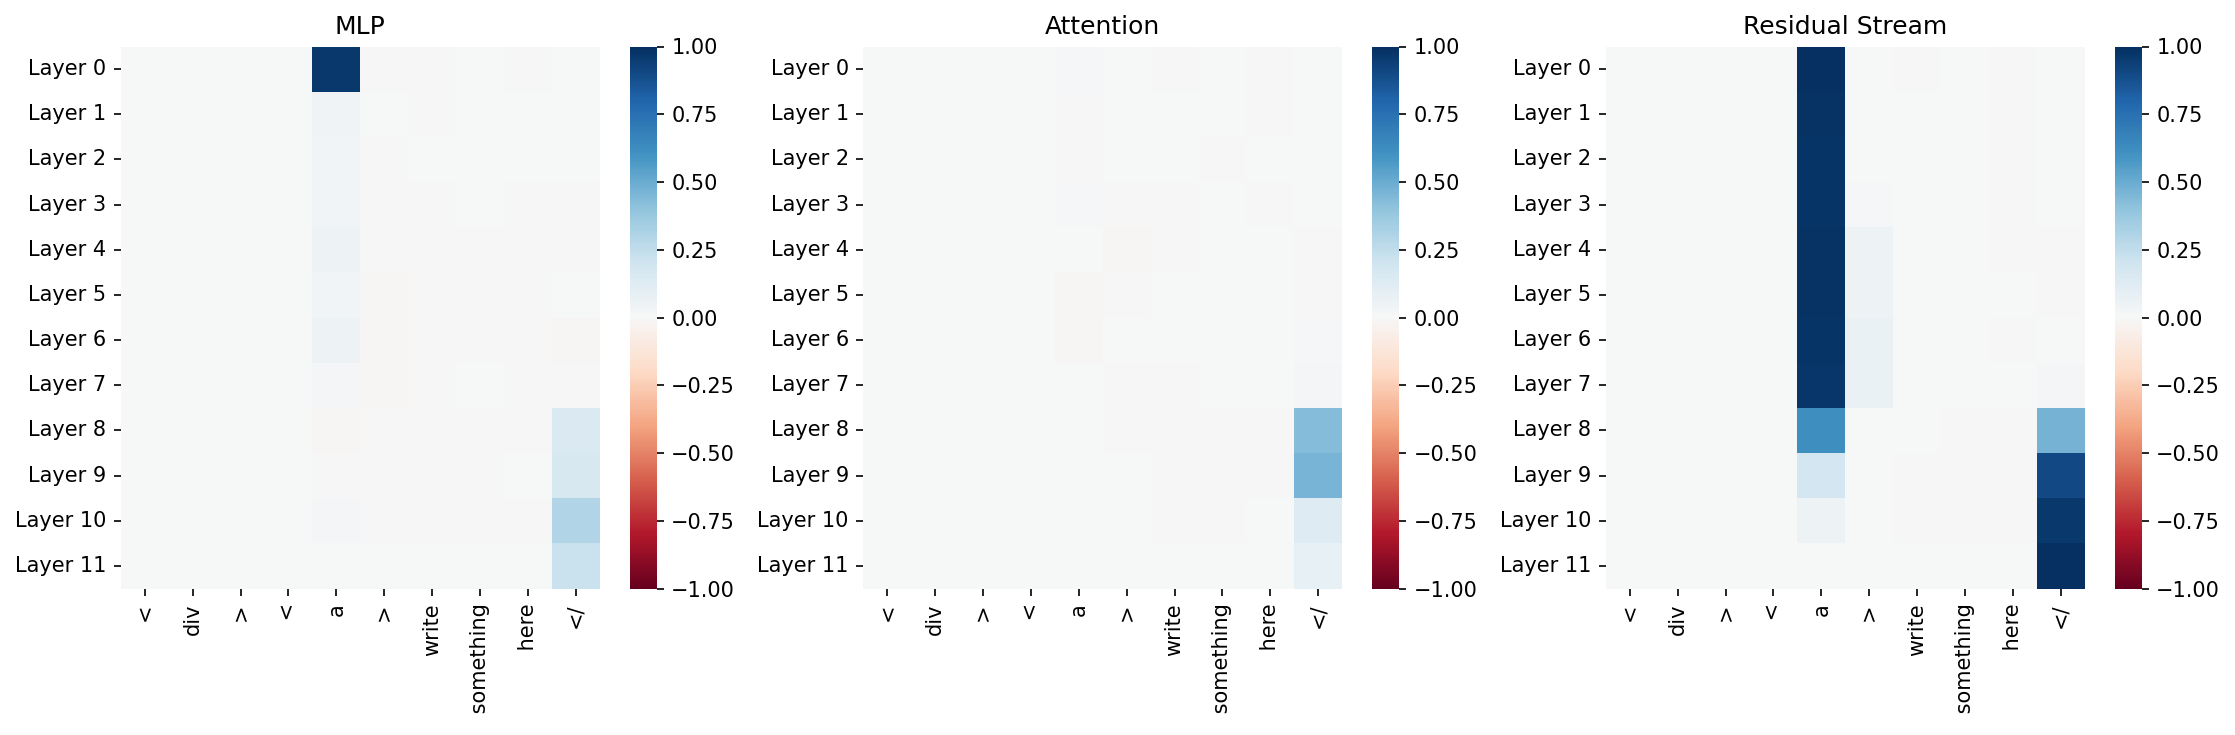

In [437]:
fig = plot_ap(model, clean_prompt, corrupted_prompt, correct_ans, incorrect_ans)
fig.show()

In [438]:
with torch.no_grad():
    _, cache = model.run_with_cache(model.to_tokens(clean_prompt))

attn_pattern_l8 = cache['blocks.8.attn.hook_pattern'][0]
attn_pattern_l9 = cache['blocks.9.attn.hook_pattern'][0]

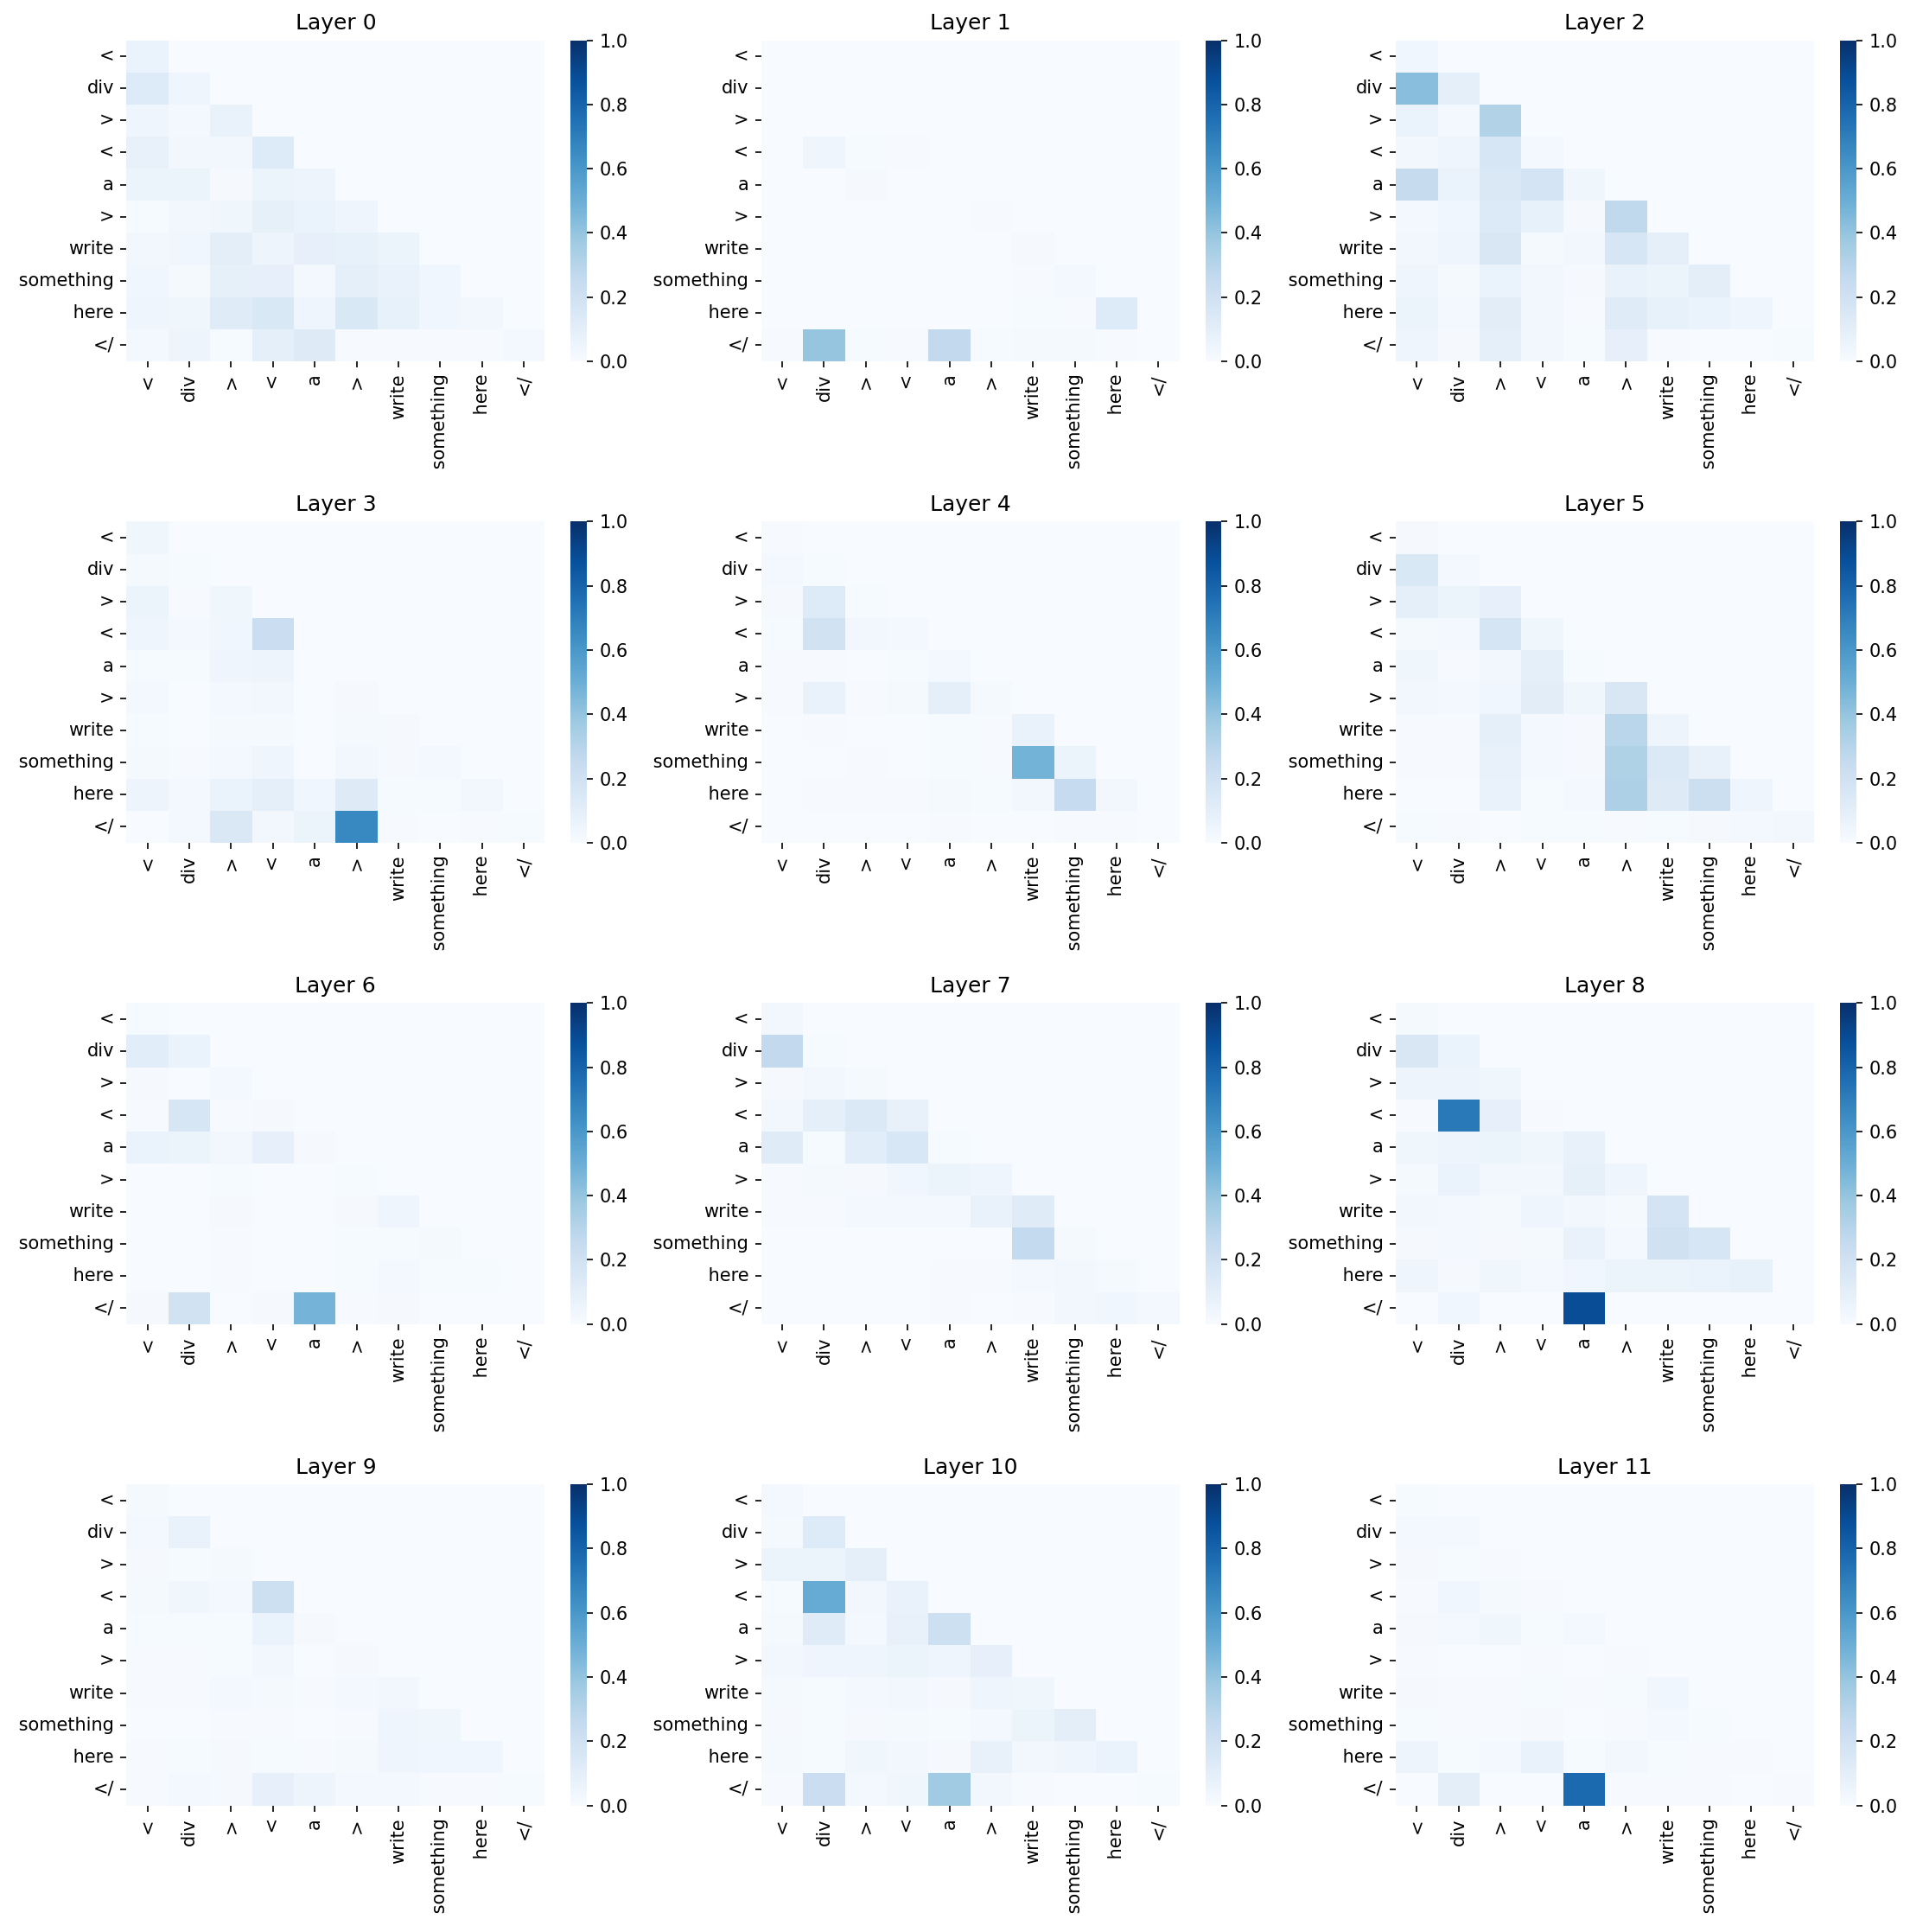

In [439]:
fig = visualize_attn_patter(attn_pattern_l8, clean_prompt)

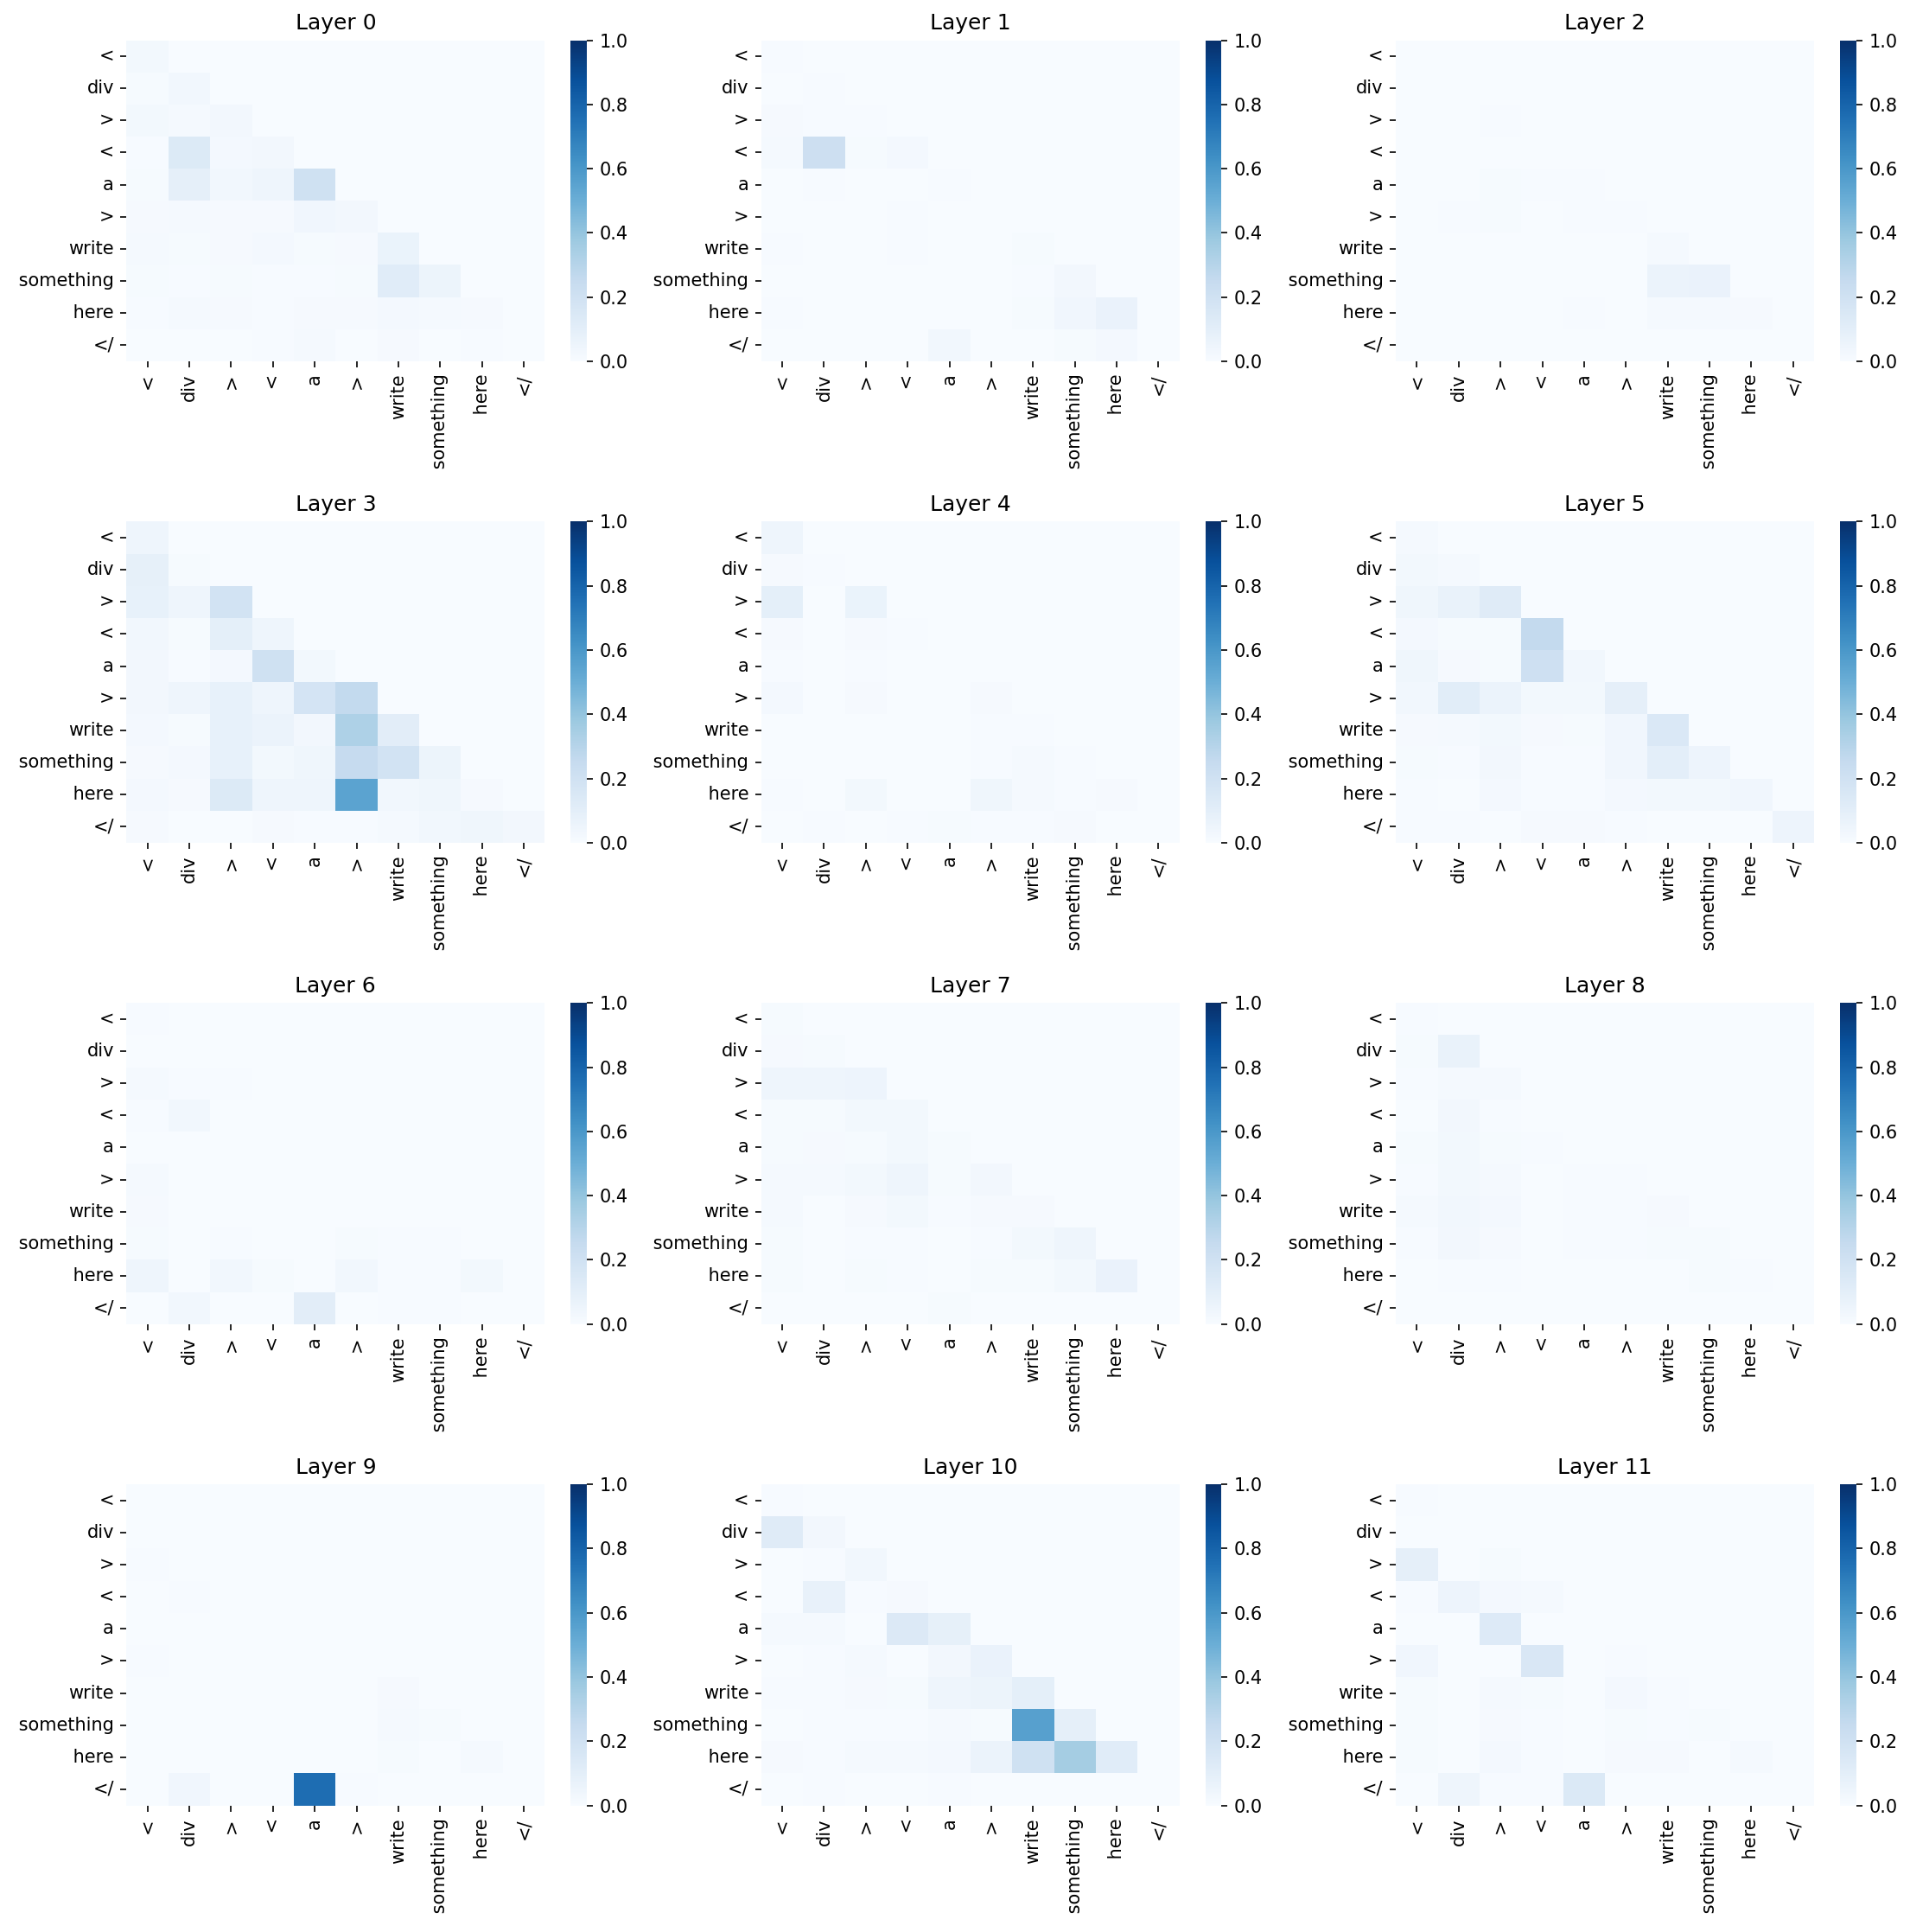

In [440]:
fig = visualize_attn_patter(attn_pattern_l9, clean_prompt)

### Closing the second tag

In [441]:
clean_prompt = "<p> <a>write here</a> </"
corrupted_prompt = "<div> <a>write here</a> </"

clean_tokens = model.to_tokens(clean_prompt)
corrupted_tokens = model.to_tokens(corrupted_prompt)

correct_ans = "p"
incorrect_ans = "div"

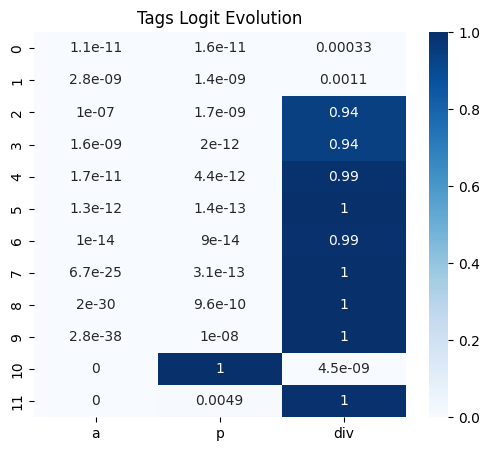

In [442]:
fig = plot_tag_logits(model, clean_prompt, ["a", "p", "div"], range(12))
fig.show()

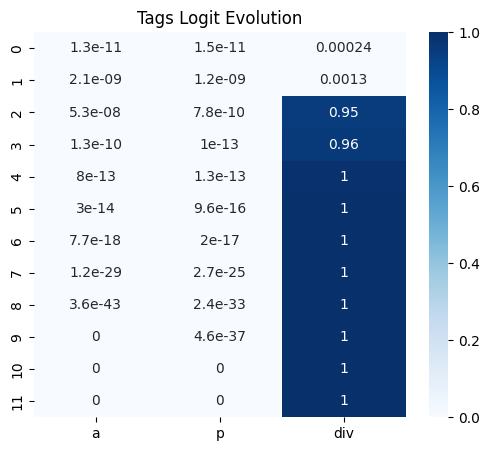

In [443]:
fig = plot_tag_logits(model, corrupted_prompt, ["a", "p", "div"], range(12))
fig.show()

Clean logit difference: 2.278
Corrupted logit difference: -6.684
Running patching...


  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:03<00:00,  3.00it/s]


Clean logit difference: 2.278
Corrupted logit difference: -6.684
Running patching...


100%|██████████| 12/12 [00:03<00:00,  3.84it/s]


Clean logit difference: 2.278
Corrupted logit difference: -6.684
Running patching...


100%|██████████| 12/12 [00:03<00:00,  3.90it/s]


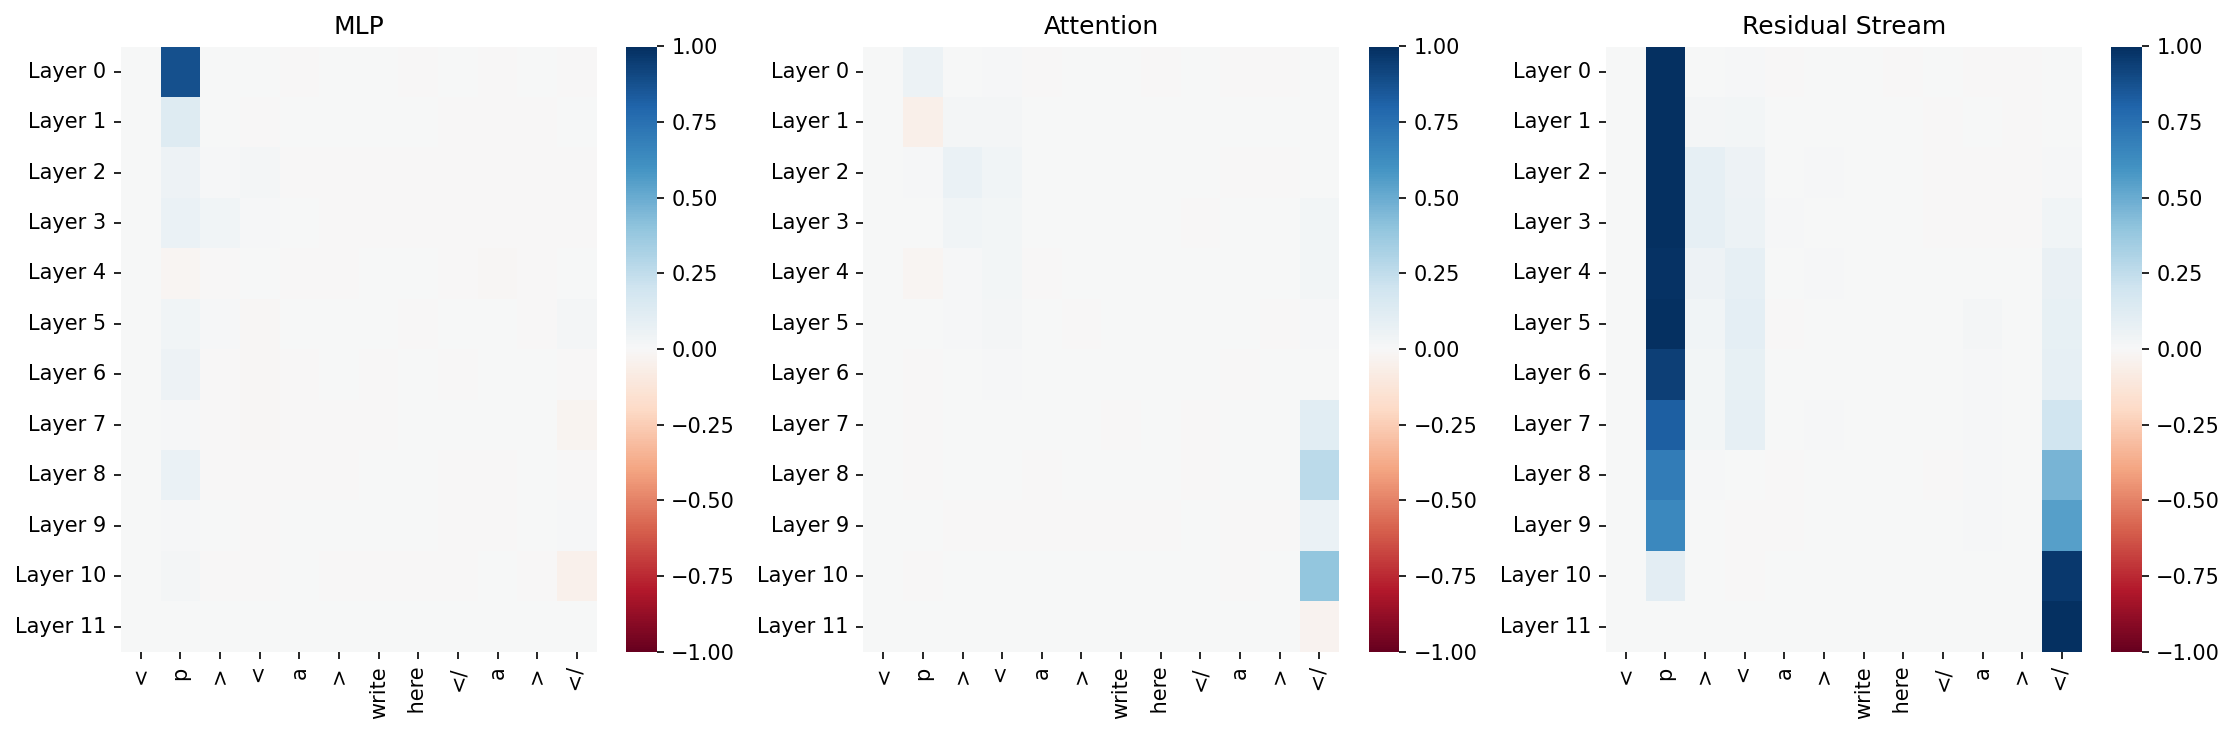

In [444]:
fig = plot_ap(model, clean_prompt, corrupted_prompt, correct_ans, incorrect_ans)

In [445]:
with torch.no_grad():
    _, cache = model.run_with_cache(model.to_tokens(clean_prompt))

attn_pattern_l8 = cache['blocks.8.attn.hook_pattern'][0]
attn_pattern_l10 = cache['blocks.10.attn.hook_pattern'][0]

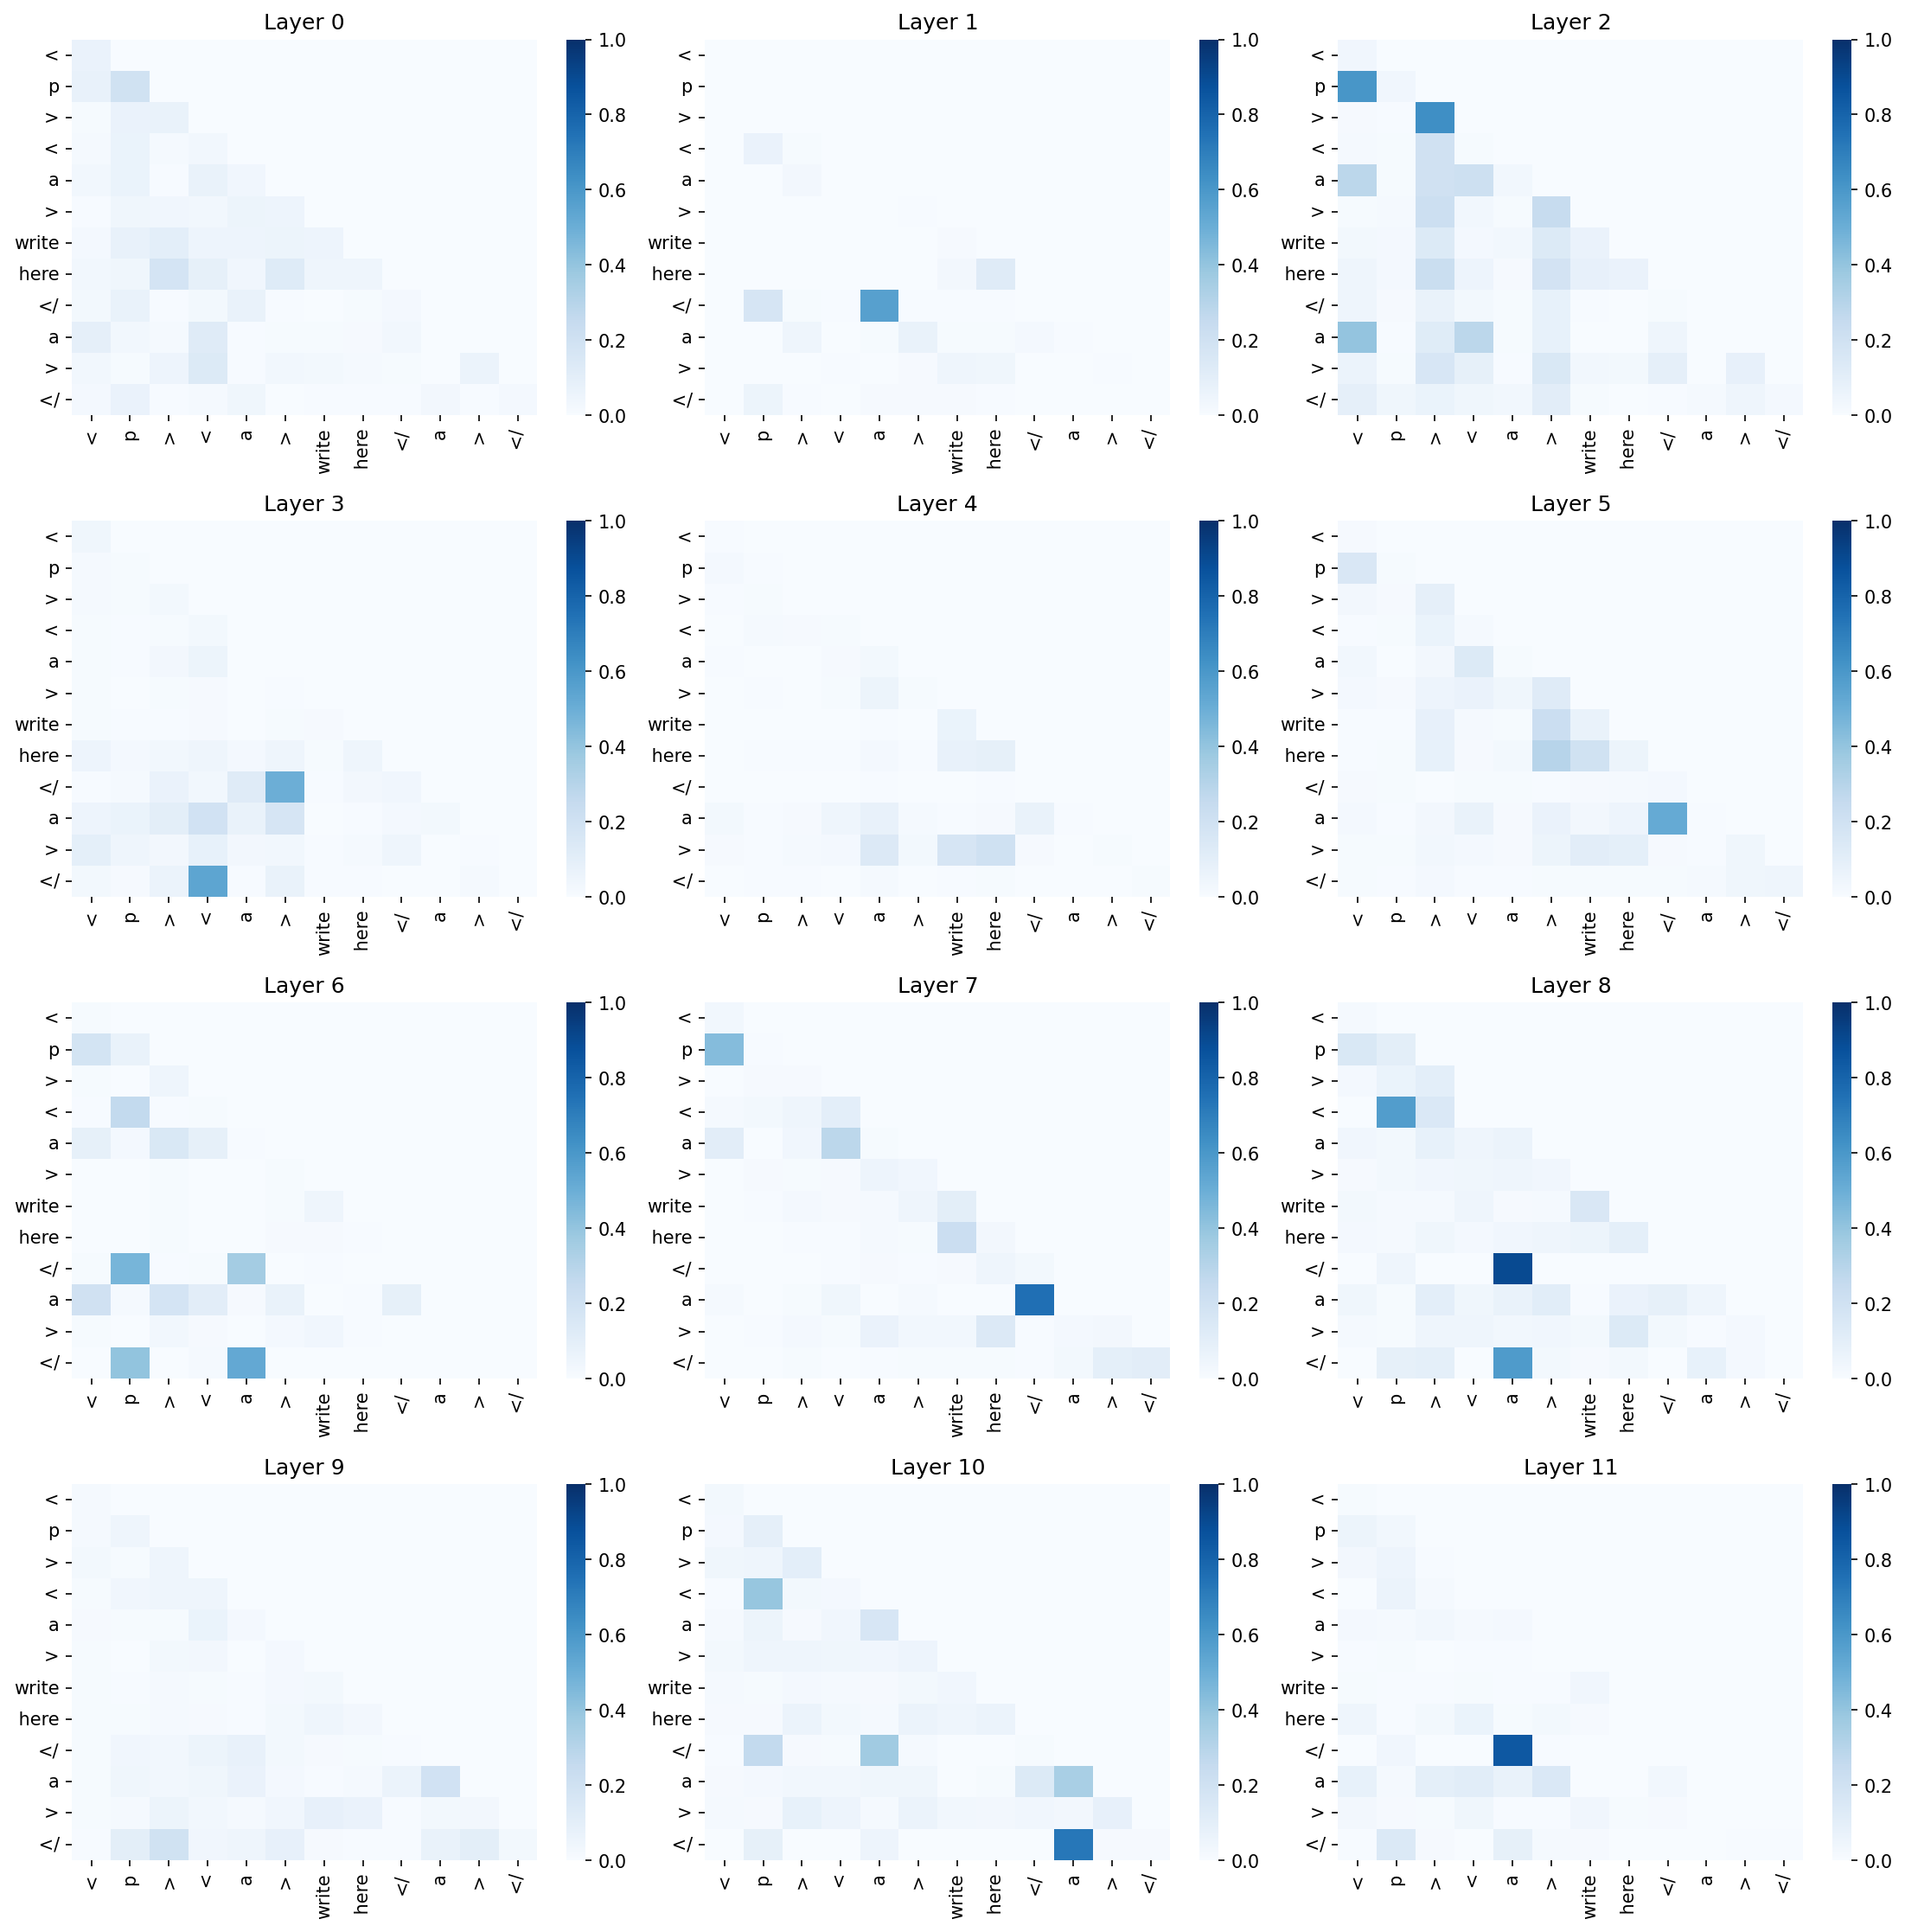

In [446]:
fig = visualize_attn_patter(attn_pattern_l8, clean_prompt)

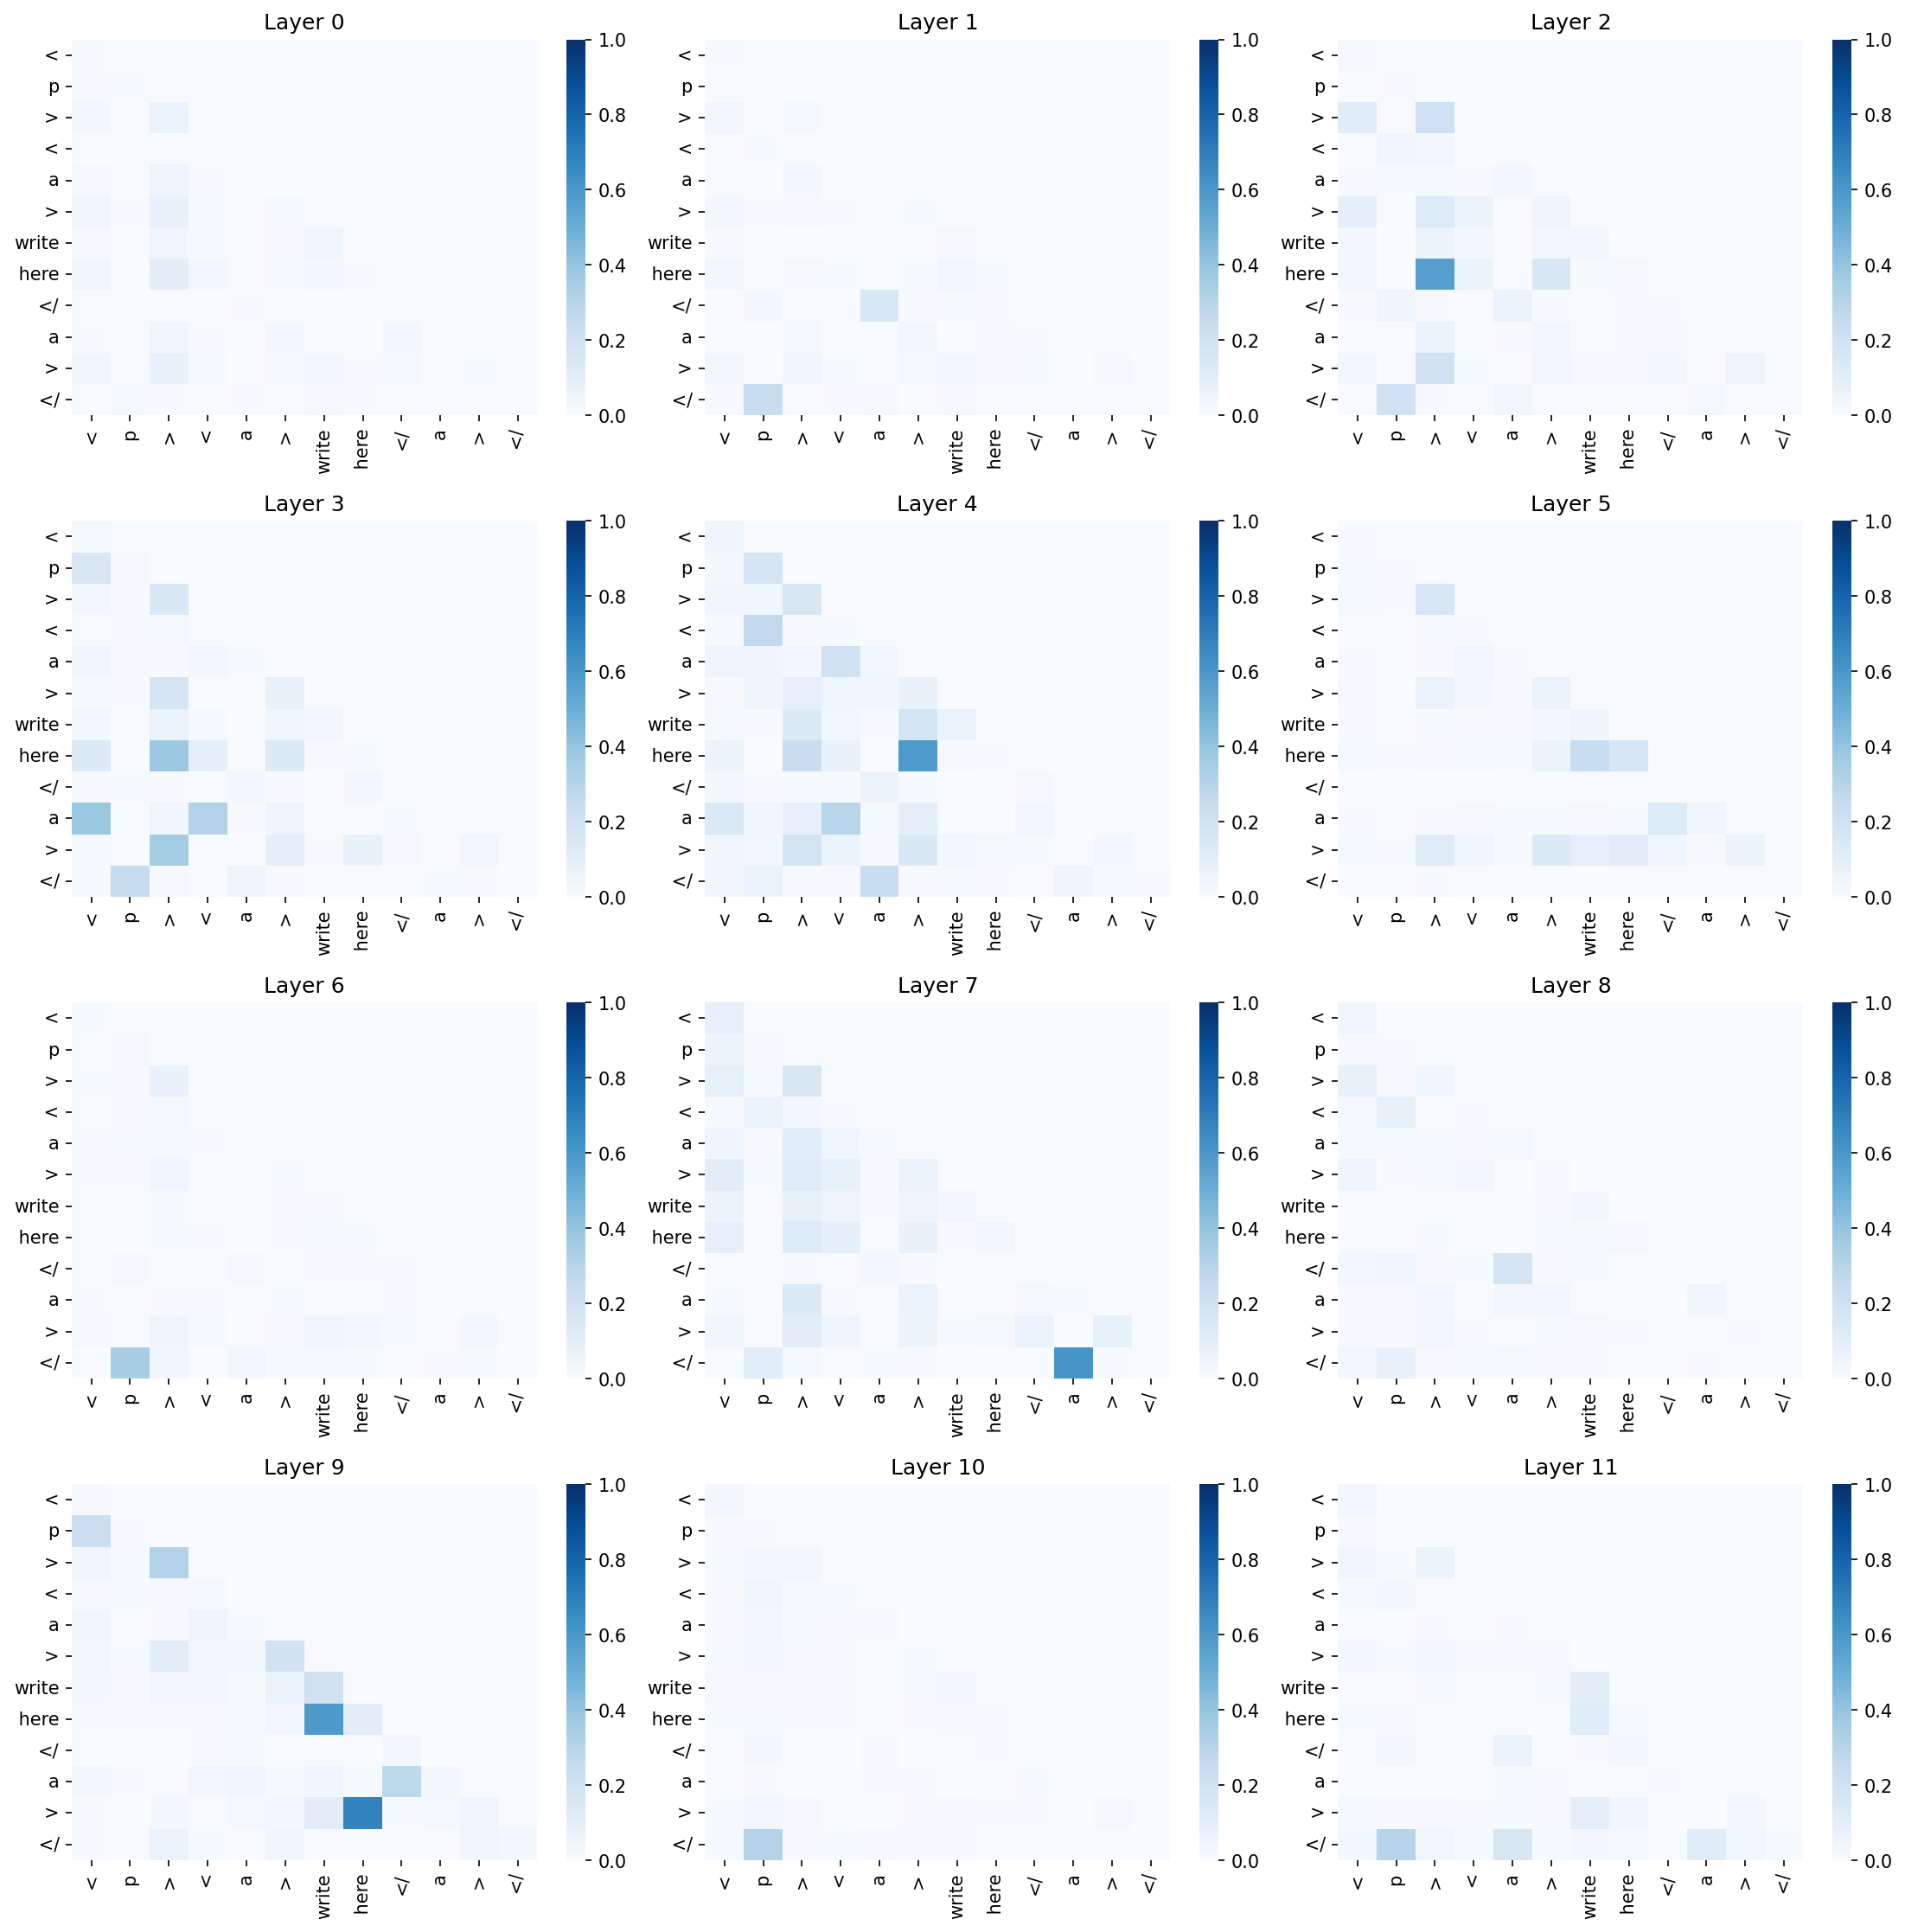

In [447]:
fig = visualize_attn_patter(attn_pattern_l10, clean_prompt)

### Other experiments

Identation effect?

In [257]:
prompt = """
<html>
<head>
    <meta charset="UTF-8">
    <title>Flight Booking</title>
</head>
<body>
    <div>
    <h1>Flight Booking</h1>
    <p>Fill in the form below to book your flight.</p>
    <ul>
        <li><label for="name">Name:</label><input type="text" id="name"></li>
        <li><label for="email">Email:</label><input type="email" id="email"></li>
    </"""

print(generate(model, prompt, max_new_tokens=2))


<html>
<head>
    <meta charset="UTF-8">
    <title>Flight Booking</title>
</head>
<body>
    <div>
    <h1>Flight Booking</h1>
    <p>Fill in the form below to book your flight.</p>
    <ul>
        <li><label for="name">Name:</label><input type="text" id="name"></li>
        <li><label for="email">Email:</label><input type="email" id="email"></li>
    </ul>


In [272]:
html_tags = np.array(['div', 'h1', 'p', 'a', 'img', 'ul', 'li', 'ol', 'table', 'tr', 'td', 'th', 'form', 'input', 'button', 'label', 'select', 'option', 'textarea', 'span', 'br', 'hr', 'link', 'style', 'script', 'meta', 'title', 'head', 'html', 'body'])
html_tags_tokens = model.to_tokens(html_tags)[:, 1]

with torch.no_grad():
    _, cache = model.run_with_cache(model.to_tokens(prompt))

logits = [model.unembed(cache[f"blocks.{l}.hook_resid_post"])[0, -1, :] for l in range(nl)]
proba = torch.cat([torch.softmax(logits, dim=-1)[None] for logits in logits])

px.imshow(proba[:, html_tags_tokens].cpu().detach(), y=list(range(nl)), x=html_tags)

In [287]:
import numpy as np

with torch.no_grad():
    proba = model(model.to_tokens("<html>\n<head>...</head><body>\n<")).softmax(dim=-1)

html_tags = np.array(['div', 'h1', 'p', 'a', 'img', 'ul', 'li', 'ol', 'table', 'tr', 'td', 'th', 'form', 'input', 'button', 'label', 'select', 'option', 'textarea', 'span', 'br', 'hr', 'link', 'style', 'script', 'meta', 'title', 'head', 'html', 'body'])
html_tags_tokens = model.to_tokens(html_tags)[:, 1]

sort_idx = proba[0, -1, html_tags_tokens].argsort(descending=True).cpu().numpy()
px.bar(x=html_tags[sort_idx], y=proba[0, -1, html_tags_tokens][sort_idx].cpu().numpy())